# Analysing the pipeline results

Drought is an extremely damaging natural hazard. Operational drought monitoring often uses satellite measurements to determine drought severity and extent. In Kenya, the National Drought Monitoring Authority uses the **Vegetation Condition Index (VCI)** to determine whether or not to distribute emergency funds to counties ([Klitsch and Atsberger 2016](https://www.mdpi.com/2072-4292/8/4/267/htm))

Here we demonstrate the usefulness of our pipeline for predicting VCI from pre-existing hydrological and meteorological conditions.

Our goal is to accurately predict *VCI* one month ahead. This would allow the Kenyan Drought Authority to proactively distribute funds ahead of damaging events. Machine learning has already been applied to this problem with impressive results ([Adede et al 2019](https://www.mdpi.com/2072-4292/11/9/1099/htm)). Can we do better?

# Get the data!

### 1. download the zip file
Go to the [following link](http://www.mediafire.com/file/mjklb3xigrz7rzb/zip_data_2.zip/file) and download the `zip_data.zip` file

```
http://www.mediafire.com/file/mjklb3xigrz7rzb/zip_data_2.zip/file
```

### 1. unzip the file in `data/` directory

Move this folder into your `ml_drought/data` directory!


Unzip the file.

On Mac this is as simple as double clicking. 

If you wish to unzip using a command line interface running `bash`:

```bash
unzip zip_data.zip
```

Your `ml_drought` directory should look something like this:

```
ml_drought
├── Dockerfile
├── README.md
├── data
    ├── zip_data.zip
    ├── zip_data
├── environment.mac.yml
├── environment.ubuntu.cpu.gdal.yml
├── environment.ubuntu.cpu.yml
├── mypy.ini
├── notebooks
├── pipeline_config
├── pytest.ini
├── run.py
├── scripts
├── src
└── tests
```


# On to the analysis!

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/zip_data')

assert data_dir.exists(), f'Make sure ' \
    'that you have downloaded and unzipped the ' \
    'zip_data. This contains the processed data ' \
    'required to run the Notebook!'

## Making Predictions

We have a pretrained model in the zipped data directory. Here we will make the predictions with the **EALSTM** model and the baseline **persistence** model.

We are making predictions from the data in `zip_data/features/one_month_forecast/test`. This is managed entirely by the pipeline so if you were to run the pipeline end-to-end the data would be in the correct format to use the same workflow.

The following cells will populate the `zip_data/models/one_month_forecast/ealstm` and `zip_data/models/one_month_forecast/previous_month` directories with the results of the predictions (saved as `netCDF` files).

In [5]:
from src.models import load_model, Persistence

In [32]:
# make predictions and save results to .nc with BASELINE model
persistence = Persistence(data_folder=data_dir)

if not len([
    f for f 
    in (data_dir / 'models' / 'one_month_forecast' / 'previous_month').glob('*.nc')
]) == 12:
    persistence.evaluate(
        save_results=True,
        save_preds=True,
    )

In [33]:
ealstm_path = data_dir / 'models/one_month_forecast/ealstm/model.pt'
assert ealstm_path.exists(), \
    'Expected the unzipped file to have the model.pt file saved'

ealstm = load_model(model_path=ealstm_path)

In [8]:
# make predictions and save results to .nc with EALSTM model
if not len([
    f for f 
    in (data_dir / 'models' / 'one_month_forecast' / 'ealstm').glob('*.nc')
]) == 12:
    ealstm.evaluate(
        save_results=True,
        save_preds=True,
    )

RMSE: 14.629349708557129


## Model Evaluation Metrics

You can see the test RMSE across all timesteps is printed as an output of the `.evaluate()` function. However, just looking at this `global` error metric hides a lot of information about when the model performs well, and when it performs poorly.

Most of the functions for extracted are defined in `src/analysis/evaluation.py`. They are accesible through `src.analysis`.

Since the `data/` directory is managed by the pipeline it is easy to just specify the models and the metric of interest. Currently we have `rmse` and `r2` defined.

### How does our model perform over time?

In [9]:
from src.analysis import annual_scores

In [10]:
# load the monthly scores dictionary
monthly_scores = annual_scores(
    data_path=data_dir,
    models=['ealstm', 'previous_month'],
    metrics=['rmse', 'r2'],
    verbose=False,
    to_dataframe=False
)

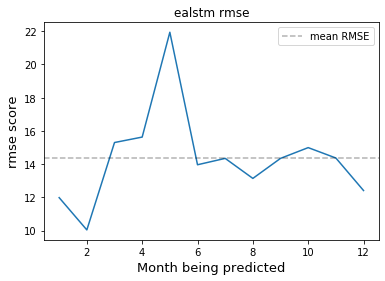

In [11]:
metric = 'rmse'
for model in ['ealstm']:
    plt.clf()
    plt.plot(monthly_scores[metric]['month'], monthly_scores[metric][model])
    plt.xlabel('Month being predicted', size=13)
    plt.ylabel(f'{metric} score', size=13)
    ax = plt.gca()
    ax.axhline(
        np.mean(monthly_scores[metric][model]), 
        ls='--', c='k', alpha=0.3, label='mean RMSE'
    )
    plt.title(f'{model} {metric}')
    plt.legend()
    plt.show()

In [12]:
# extract DataFrame for easier comparison
scores = annual_scores(
    data_path=data_dir,
    models=['ealstm', 'previous_month'],
    metrics=['rmse', 'r2'],
    verbose=False,
    to_dataframe=True
)

scores_long = pd.melt(
    scores, id_vars=['month', 'metric'], 
    value_vars=['ealstm', 'previous_month']
)

# get the rmse metrics for plotting
rmse = scores_long.loc[scores_long.metric=='rmse']

## Comparing predictions against the truth

We can either use the built in plotting functionality for comparing true and predicted data, or else we can load the data ourselves and use the flexibility of `xarray`. This is because all of the data is saved to `netCDF` files (`.nc`).

We do relatively well compared to the baseline in April.

For month 4, ealstm error: 12.28342056274414


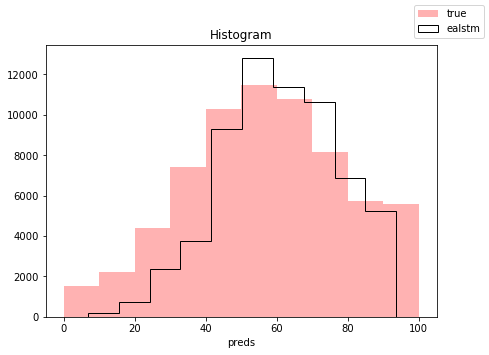

<Figure size 432x288 with 0 Axes>

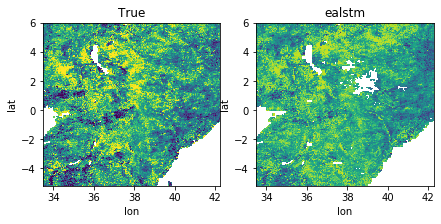

In [13]:
from src.analysis import plot_predictions

plot_predictions(
    pred_month=4, model='ealstm', 
    target_var='VCI', data_path=data_dir
)

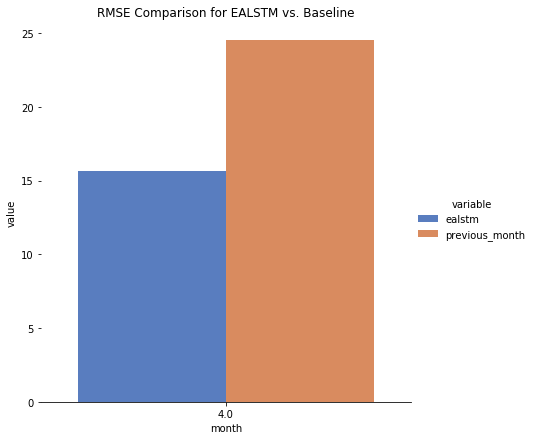

In [14]:
import seaborn as sns

g = sns.catplot(x="month", y="value", hue="variable", data=rmse.loc[rmse.month == 4],
                height=6, kind="bar", palette="muted")
g.despine(left=True)
ax = plt.gca()
ax.set_title('RMSE Comparison for EALSTM vs. Baseline');

### When does our model fail?

But we do poorly in May! In fact, we do even worse than the baseline model. This definitely warrants further research and will be the focus of our ongoing work.

For month 5, ealstm error: 17.241186141967773


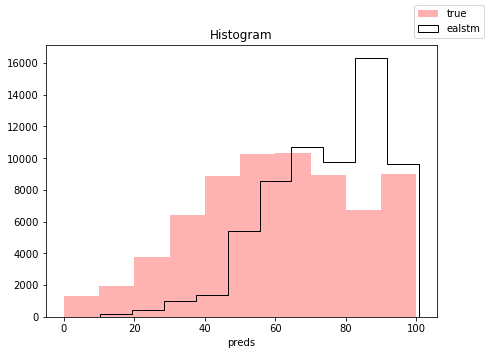

<Figure size 432x288 with 0 Axes>

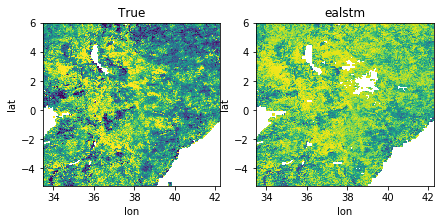

In [15]:
plot_predictions(
    pred_month=5, model='ealstm', 
    target_var='VCI', data_path=data_dir
);

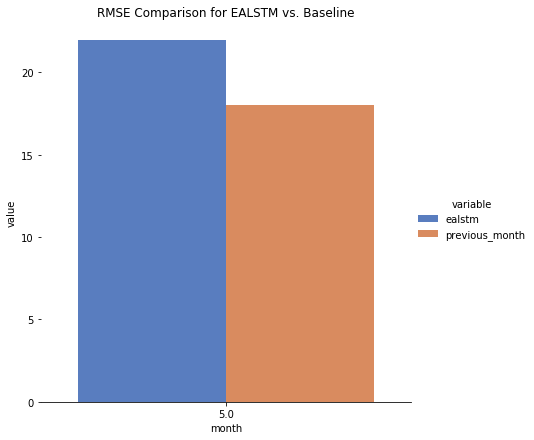

In [16]:
g = sns.catplot(x="month", y="value", hue="variable", data=rmse.loc[rmse.month == 5],
                height=6, kind="bar", palette="muted")
g.despine(left=True)
ax = plt.gca()
ax.set_title('RMSE Comparison for EALSTM vs. Baseline');

## Comparison over Administrative Units

In order to make the results comparable with [Adede et al 2019](https://www.mdpi.com/2072-4292/11/9/1099/htm) and other existing work we provide grouping functionality. 

The first groupby objects aggregate the analysis by administrative regions. We also provide functionality to explore results by landcover.

We have used the `exporters` to [download shapefiles](https://data.humdata.org/dataset/47-counties-of-kenya). We then use the `preprocessors` to rasterize these shapefiles into pixel-level `netCDF` objects which can then be used by the `AdministrativeRegionAnalysis` to produce aggregate statistics per region.

**NOTE**: this code requires `geopandas` to be installed.

In [17]:
from src.analysis import AdministrativeRegionAnalysis
# from src.analysis import KenyaGroupbyRegion

In [18]:
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)
analyzer.analyze()

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'previous_month']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
* Analyzing for district_l2_kenya *

** Analyzing for ealstm-district_l2_kenya **
** Written ealstm csv to /Volumes/Lees_Extend/data/zip_data/analysis/region_analysis/ealstm/ealstm_district_l2_kenya.csv **

** Analyzing for previous_month-district_l2_kenya **
** Written previous_month csv to /Volumes/Lees_Extend/data/zip_data/analysis/region_analysis/previous_month/previous_month_district_l2_kenya.csv **
* Assigned all region dfs to `self.df` *

* Assigned Global Error Metrics to `self.global_mean_metrics` *
* Written csv to data/analysis/region_analysis/global_error_metrics_one_month_forecast_admin.csv *

* Assigned Regional Error Metrics to `self.regional_mean_metrics` *
* Written csv to data/analysis/region_analysis/regional_error_metrics_one_month_forecast_admin.csv *


In [19]:
# extract a GeoDataFrame that we can plot
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
metric_gdf = region_plotter.gdf
metric_gdf.head()

The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,model,admin_level_name,region_name,rmse,mae,r2,DISTNAME,geometry
0,ealstm,district_l2_kenya,NAIROBI,13.034867,9.907392,-0.674941,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,previous_month,district_l2_kenya,NAIROBI,11.051595,9.795107,-0.204027,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,ealstm,district_l2_kenya,SAMBURU,6.926626,5.606387,0.573924,SAMBURU,"POLYGON ((36.75165473150634 2.519848937106019,..."
3,previous_month,district_l2_kenya,SAMBURU,7.961759,5.947568,0.437061,SAMBURU,"POLYGON ((36.75165473150634 2.519848937106019,..."
4,ealstm,district_l2_kenya,TRANS MARA,9.777603,7.809506,-0.072351,TRANS MARA,POLYGON ((35.15025473150634 -0.959251062893981...


### How does the error vary in each region?

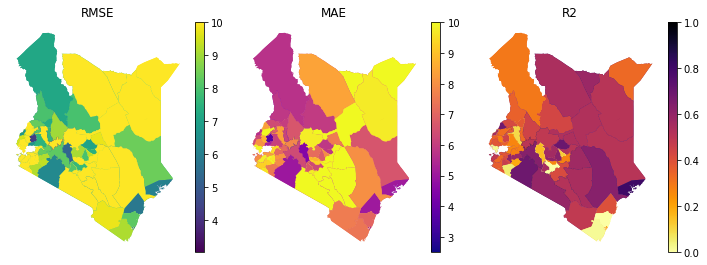

In [20]:
region_plotter.plot_all_regional_error_metrics(metric_gdf);

### How do we do when we compare to the [Adede et al 2019](https://www.mdpi.com/2072-4292/11/9/1099/htm) paper?

The paper presents $R^2$ results for four districts:
- Mandera - 0.71
- Marsabit - 0.77
- Turkana - 0.83
- Wajir - 0.71

These are defined as Arid and Semi Arid Lands (ASAL) districts. They are actively monitored by the National Drought Management Authority.

In [21]:
# join true/preds into a GeoDataFrame
gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
gdf.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,ealstm,2018-01-31,NAIROBI,27.561455,23.551954,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,previous_month,2018-01-31,NAIROBI,32.159204,23.551954,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,district_l2_kenya,previous_month,2018-02-28,NAIROBI,23.551954,20.263123,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
3,district_l2_kenya,ealstm,2018-02-28,NAIROBI,29.441332,20.263123,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
4,district_l2_kenya,previous_month,2018-03-31,NAIROBI,20.263125,29.301306,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


In [23]:
from sklearn.metrics import r2_score
from typing import Dict

def rolling_average(district_csv: pd.DataFrame) -> Dict[str, float]:
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']

    district_csv['month'] = pd.to_datetime(district_csv.datetime).dt.month

    output_dict: Dict[str: float] = {}

    for district in relevant_districts:
        district_df = district_csv[district_csv.region_name == district.upper()]
        true, predicted = [], []
        for i in range(1, 12 - 1):
            min_month = i
            max_month = i + 3
            submonth = district_df[(district_df.month >= min_month) & (district_df.month < max_month)]
            predicted.append(submonth.predicted_mean_value.mean())
            true.append(submonth.true_mean_value.mean())
        district_score = r2_score(true, predicted)
        print(f'For {district}, r2 score: {district_score}')
        output_dict[district] = district_score
    
    return output_dict

In [24]:
out_dict = rolling_average(gdf)

For Mandera, r2 score: 0.8112829460880505
For Marsabit, r2 score: 0.7112375264618641
For Turkana, r2 score: 0.4814838266795506
For Wajir, r2 score: 0.7490039572526067


You can see that we have better performance in `Wajir` and `Mandera`, however we do significantly worse in `Turkana` and slightly worse in `Marsabit`. 

We are currently investigating the reasons behind this. Also note, that as we update our models (trained and saved in the `model.pt` file) these results change.

## Interpretable Machine Learning

One of the key criticisms lobbied against machine learning based approaches is that the models are *black boxes*. During the Summer of Weather Code project, one of our key focuses was making the results interpretable. The key method for doing this in our pipeline is through using [SHAP values](https://github.com/slundberg/shap).

SHAP Values allow you to interrogate the relative importance of a feature for a prediction. They are measured in the units of the variable of interest and so a SHAP value of $-1$ means that feature $x$ negatively impacted VCI by a value of $-1$. 

All feature SHAP values sum to the prediction, so if you summed all SHAP values across all features you would recover the predicted VCI value.

For more information about SHAP values check the paper by [Lundberg et al 2018](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions).

Here we will demonstrate how SHAP values can be used in our context.

In [25]:
from src.analysis import plot_shap_values

analysis_dir = data_dir / 'models/one_month_forecast/ealstm/analysis/2018_3'
assert analysis_dir.exists()

In [26]:
# load the shap values
shap_historical = np.load(analysis_dir / 'shap_value_historical.npy')
with (analysis_dir / 'input_ModelArray.pkl').open('rb') as f:
    model_array = pickle.load(f)
with (data_dir / 'features/one_month_forecast/normalizing_dict.pkl').open('rb') as f:
    norm_dict = pickle.load(f)

In [27]:
variable_names = model_array.x_vars
input_historical = model_array.x.historical.numpy()
latlons = model_array.latlons
input_pred_months = model_array.x.pred_months.numpy()
shap_pred_months = shap_static = np.load(analysis_dir / 'shap_value_pred_months.npy')

Here we are looking at the contribution of each feature to the predictions we make from the model for March 2018. SHAP values require calculating the gradient for the neural networks. Therefore, they can take a relatively long time to compute. That is why we have provided the data for you in this instance.

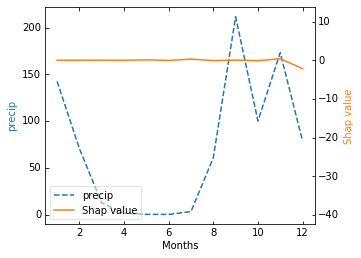

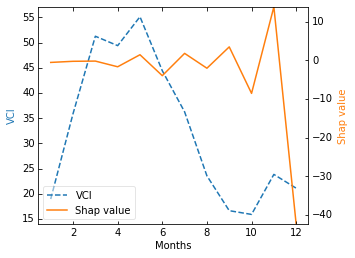

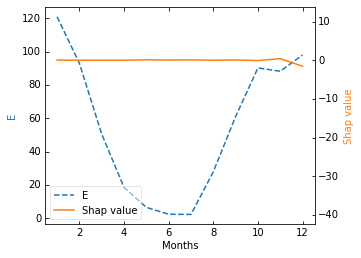

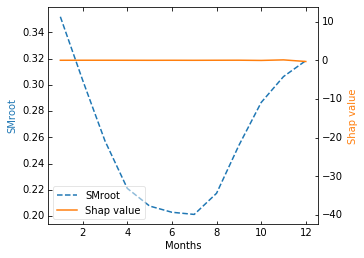

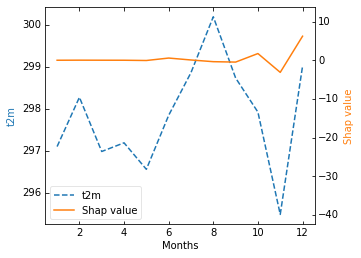

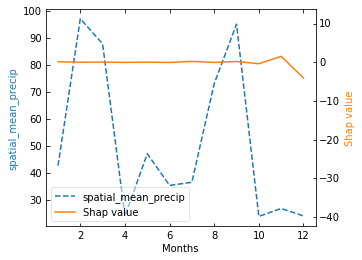

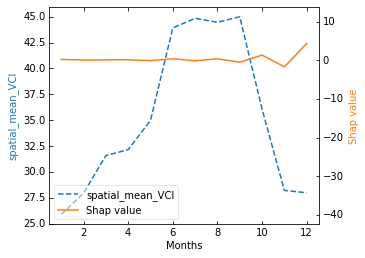

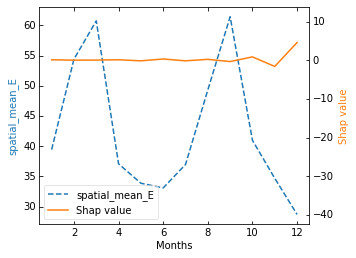

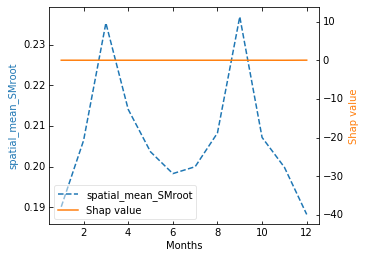

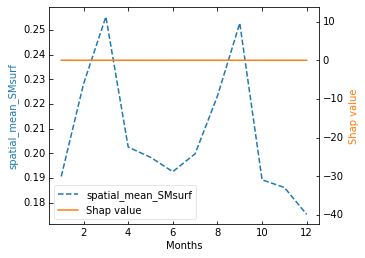

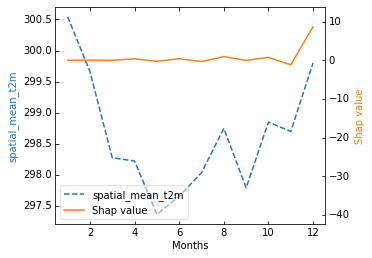

In [35]:
# only use the valid variables
ignore_vars = ['stl1', 'SMsurf', 'spatial_mean_stl1', 'spatial_mean_stl1_SMsurf']
valid_variables = np.array(variable_names)[~np.isin(variable_names, ignore_vars)]

for var in valid_variables:
    plt.clf()
    plot_shap_values(input_historical[0], shap_historical[0], variable_names, norm_dict, var, show=False,
                     pred_date=None)
    plt.savefig(analysis_dir/f'shap_plot_{var}.png', dpi=300, bbox_inches='tight')
    plt.show()

Remember, all of these plots show how that feature changed the prediction for <b>March 2018</b>.

The plots above show the SHAP values for each variable over time. Because our EALSTM model is currently using the previous 12 months as input, the <b style="color: orange">orange</b> lines show the importance of that feature at that timestep.

#### Temperature 

The background <b style="color: blue">blue</b> lines show the actual values for that variable. If we look at the plot for 2m Air Temperature (`t2m`) we can see that temperature is not important until three months before (Dec, Jan, Feb). This can be interpreted as follows:

The temperature in February 2018 increased our prediction of VCI in March 2018 by a value of ~ $+6$


#### VCI

You can see that the autoregressive information is particularly important to the model. The plot for VCI shows that the February VCI is strongly negatively impacting our prediction in March. The VCI in February decreases our prediction for March VCI by ~$-40$. This is relative to a baseline prediction, which is the mean March VCI in the dataset.